Twitter Sentiment Analysis
Moin Ahmed

# Imports

In [ ]:
import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem.porter import *

!pip install emoji --upgrade
import emoji

import re,string

from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings("ignore")

Requirement already up-to-date: emoji in /usr/local/lib/python3.7/dist-packages (1.2.0)


In [ ]:
nltk.download('twitter_samples')

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


True

# Preprocessing

In [ ]:
from nltk.corpus import twitter_samples

pos_tweets = twitter_samples.strings('positive_tweets.json')
neg_tweets = twitter_samples.strings('negative_tweets.json')

pos_df = pd.DataFrame(pos_tweets, columns = ['tweet'])

neg_df = pd.DataFrame(neg_tweets, columns = ['tweet'])

Replace Emojis and Emoticons with

In [ ]:
def load_dict_smileys():
    return {
        ":‑)":"smiley", ":-]":"smiley", ":-3":"smiley", ":->":"smiley", "8-)":"smiley", ":-}":"smiley",
        ":)":"smiley", ":]":"smiley", ":3":"smiley", ":>":"smiley", "8)":"smiley", ":}":"smiley", ":o)":"smiley", 
        ":c)":"smiley", ":^)":"smiley", "=]":"smiley", "=)":"smiley", ":-))":"smiley", ":‑D":"smiley", "8‑D":"smiley",
        "x‑D":"smiley", "X‑D":"smiley", ":D":"smiley", "8D":"smiley", "xD":"smiley", "XD":"smiley",
        ":‑(":"sad", ":‑c":"sad", ":‑<":"sad", ":‑[":"sad", ":(":"sad", ":c":"sad", ":<":"sad", ":[":"sad",
        ":-||":"sad", ">:[":"sad", ":{":"sad", ":@":"sad", ">:(":"sad", ":'‑(":"sad", ":'(":"sad",
        ":‑P":"playful", "X‑P":"playful", "x‑p":"playful", ":‑p":"playful", ":‑Þ":"playful", ":‑þ":"playful",
        ":‑b":"playful", ":P":"playful", "XP":"playful", "xp":"playful", ":p":"playful", ":Þ":"playful",
        ":þ":"playful", ":b":"playful",
        "<3":"love"
        }

In [ ]:
def replace_emoji_emoticon(tweet):
    SMILEY = load_dict_smileys()  
    words = tweet.split()
    tweet = " ".join([SMILEY[word] if word in SMILEY else word for word in words])
    tweet = emoji.demojize(tweet)
    return tweet

pos_df['tweet'] = pos_df['tweet'].apply(replace_emoji_emoticon)
neg_df['tweet'] = neg_df['tweet'].apply(replace_emoji_emoticon)

Remove hyperlinks, hashtags and username

In [ ]:
def strip_links(text):
    link_regex = re.compile(
        '((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)',
        re.DOTALL)
    links = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

pos_df['tweet'] = pos_df['tweet'].apply(strip_links)
pos_df['tweet'] = pos_df['tweet'].apply(strip_all_entities)

neg_df['tweet'] = neg_df['tweet'].apply(strip_links)
neg_df['tweet'] = neg_df['tweet'].apply(strip_all_entities)

Remove RT

In [ ]:
pos_df['tweet'] = pos_df['tweet'].str.replace('RT','')
neg_df['tweet'] = neg_df['tweet'].str.replace('RT','')

Convert to lowercase

In [ ]:
pos_df['tweet'] = pos_df['tweet'].str.lower()
neg_df['tweet'] = neg_df['tweet'].str.lower()

Remove Punctuations

In [ ]:
pos_df['tweet'] = pos_df['tweet'].str.replace('[^\w\s]','')
neg_df['tweet'] = neg_df['tweet'].str.replace('[^\w\s]','')

Stop Word Removal

In [ ]:
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def stopwords(text):
    return " ".join(
        [word for word in str(text).split() if word not in STOPWORDS])

pos_df['tweet'] = pos_df['tweet'].apply(stopwords)
neg_df['tweet'] = neg_df['tweet'].apply(stopwords)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Lemmatization

In [ ]:
nltk.download('wordnet')

from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

def stem_tweet(tweet):
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, 
                               reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweet)

    words = []
    for word in tweet_tokens:
        stem_word = lemmatizer.lemmatize(word)
        words.append(stem_word)
    
    return ' '.join([word for word in words])

pos_df['tweet'] = pos_df['tweet'].apply(stem_tweet)
neg_df['tweet'] = neg_df['tweet'].apply(stem_tweet)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Balancing and Scoring

Calculate Polarity

In [ ]:
def calculate_polarity(df):
    sentiment_objects = [TextBlob(tweet) for tweet in df['tweet']]
    sentiment_values = [[str(tweet), tweet.sentiment.polarity] 
                        for tweet in sentiment_objects]
    sentiment_df = pd.DataFrame(sentiment_values, columns=["tweet", "polarity"])
    return sentiment_df

In [ ]:
pos_df = calculate_polarity(pos_df)
neg_df = calculate_polarity(neg_df)

Score the classes

In [ ]:
def calculate_score(df):
    score = []
    for i, row in df.iterrows():
        if row['polarity'] >= 0.5:
            score.append(2)
        if row['polarity'] > 0 and row['polarity'] < 0.5:
            score.append(1)
        if row['polarity'] == 0:
            score.append(0)
        if row['polarity'] >= -0.5 and row['polarity'] < 0:
            score.append(-1)
        if row['polarity'] >= -1 and row['polarity'] < -0.5:
            score.append(-2)
    df['score'] = score
    return df

In [ ]:
pos_df = calculate_score(pos_df)
neg_df = calculate_score(neg_df)

In [ ]:
pos_df['score'].value_counts()

 0    2067
 1    1465
 2    1151
-1     283
-2      34
Name: score, dtype: int64

In [ ]:
neg_df['score'].value_counts()

-1    3279
 0     849
 1     549
-2     218
 2     105
Name: score, dtype: int64

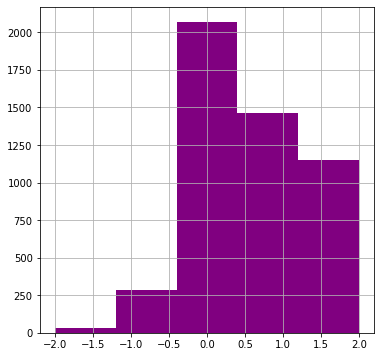

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

pos_df['score'].hist(bins=5, ax=ax, color="purple")

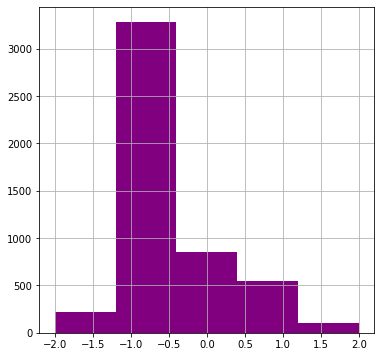

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

neg_df['score'].hist(bins=5, ax=ax, color="purple")

In [ ]:
df = pd.concat([pos_df,neg_df])

In [ ]:
df

,tweet,polarity,score
0,inte paris top engaged member community week smiley,0.500000,2
1,hey james odd please call contact centre 02392441234 able assist smiley many thanks,0.258333,1
2,listen last night smiley bleed amazing track scotland,0.300000,1
3,congrats smiley,0.000000,0
4,yeaaah yipppy accnt verified rqst succeed got blue tick mark fb profile smiley 15 day,0.000000,0
...,...,...,...
4995,wanna change avi usanele sad,-0.500000,-1
4996,puppy broke foot sad,-0.500000,-1
4997,jaebum baby picture,0.000000,0
4998,mr ahmad maslan cook sad,-0.500000,-1


In [ ]:
df['score'].value_counts()

-1    3562
 0    2916
 1    2014
 2    1256
-2     252
Name: score, dtype: int64

# Split Dataset

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.75, min_df=5, max_features=10000, 
                                 stop_words="english", ngram_range=(1,3))
X = tfidf_vectorizer.fit_transform(df['tweet'])

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, df['score'], test_size=0.3, 
                                                    random_state=5)

# Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB

MNB = MultinomialNB()
MNB.fit(X_train, Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
pred = MNB.predict(X_test)
accuracy_score = metrics.accuracy_score(pred, Y_test)
print(accuracy_score)

0.6943333333333334


In [ ]:
print(classification_report(pred, Y_test))

              precision    recall  f1-score   support

          -2       0.03      0.67      0.06         3
          -1       0.92      0.65      0.76      1511
           0       0.65      0.70      0.67       787
           1       0.53      0.73      0.61       452
           2       0.55      0.86      0.68       247

    accuracy                           0.69      3000
   macro avg       0.54      0.72      0.56      3000
weighted avg       0.76      0.69      0.71      3000



# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier 

regressor = DecisionTreeClassifier(random_state = 3)
regressor.fit(X_train, Y_train) 

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=3, splitter='best')

In [ ]:
pred = regressor.predict(X_test)
accuracy_score = metrics.accuracy_score(pred, Y_test)
print(accuracy_score)

0.8423333333333334


In [ ]:
print(classification_report(pred, Y_test))

              precision    recall  f1-score   support

          -2       0.65      0.56      0.60        78
          -1       0.89      0.92      0.90      1042
           0       0.93      0.84      0.88       947
           1       0.71      0.78      0.74       570
           2       0.76      0.81      0.78       363

    accuracy                           0.84      3000
   macro avg       0.79      0.78      0.78      3000
weighted avg       0.85      0.84      0.84      3000



# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
rfc = RandomForestClassifier(n_estimators= 300)

In [ ]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
pred = rfc.predict(X_test)

In [ ]:
accuracy_score = metrics.accuracy_score(pred, Y_test)
print(accuracy_score)

0.8486666666666667


In [ ]:
print(classification_report(pred, Y_test))

              precision    recall  f1-score   support

          -2       0.43      0.66      0.52        44
          -1       0.90      0.91      0.90      1050
           0       0.97      0.79      0.87      1047
           1       0.65      0.89      0.75       462
           2       0.85      0.82      0.83       397

    accuracy                           0.85      3000
   macro avg       0.76      0.81      0.78      3000
weighted avg       0.87      0.85      0.85      3000



# SVM

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
param_grid = {'C' : [0.1,1,10,100,1000],
              'gamma' : [1 ,0.1,0.01, 0.001,0.0001]}

In [ ]:
grid = GridSearchCV(SVC() , param_grid, verbose = 3)

In [ ]:
grid.fit(X_train , Y_train)

In [ ]:
pred = grid.predict(X_test)
accuracy_score = metrics.accuracy_score(pred, Y_test)
print(accuracy_score)

0.866


In [ ]:
print(classification_report(pred, Y_test))

              precision    recall  f1-score   support

          -2       0.62      0.66      0.64        64
          -1       0.92      0.91      0.92      1076
           0       0.96      0.84      0.89       971
           1       0.72      0.86      0.78       534
           2       0.79      0.85      0.82       355

    accuracy                           0.87      3000
   macro avg       0.80      0.82      0.81      3000
weighted avg       0.88      0.87      0.87      3000



In [ ]:
grid.best_params_

{'C': 1000, 'gamma': 0.001}

# Multinomial Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
mlr = LogisticRegression()

In [ ]:
mlr.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
pred = mlr.predict(X_test)

In [ ]:
accuracy_score = metrics.accuracy_score(pred, Y_test)
print(accuracy_score)

0.818


In [ ]:
print(classification_report(pred, Y_test))

              precision    recall  f1-score   support

          -2       0.25      0.74      0.37        23
          -1       0.90      0.88      0.89      1101
           0       0.96      0.76      0.84      1078
           1       0.63      0.82      0.71       490
           2       0.67      0.84      0.75       308

    accuracy                           0.82      3000
   macro avg       0.68      0.80      0.71      3000
weighted avg       0.85      0.82      0.83      3000

